In [1]:
import Pkg
using Revise
using JLD

In [22]:
using SNNT

In [23]:
using PyCall

In [24]:
using Plots
using LaTeXStrings

In [25]:
pyplot()

Plots.PyPlotBackend()

# Functions

In [26]:
py"""
import numpy as np
import polytope as pc
from polytope.solvers import lpsolve
def cheby_ball(poly1):
    #logger.debug('cheby ball')
    if (poly1._chebXc is not None) and (poly1._chebR is not None):
        # In case chebyshev ball already calculated and stored
        return poly1._chebR, poly1._chebXc
    if isinstance(poly1, pc.Region):
        maxr = 0
        maxx = None
        for poly in poly1.list_poly:
            rc, xc = cheby_ball(poly)
            if rc > maxr:
                maxr = rc
                maxx = xc
        poly1._chebXc = maxx
        poly1._chebR = maxr
        return maxr, maxx
    if pc.is_empty(poly1):
        return 0, None
    # `poly1` is nonempty
    r = 0
    xc = None
    A = poly1.A
    c = np.negative(np.r_[np.zeros(np.shape(A)[1]), 1])
    norm2 = np.sqrt(np.sum(A * A, axis=1))
    G = np.c_[A, norm2]
    h = poly1.b
    sol = lpsolve(c, G, h)
    #return sol
    if sol['status'] == 0 or (sol['status'] == 4 and pc.is_inside(poly1,sol['x'][0:-1])):
        r = sol['x'][-1]
        if r < 0:
            return 0, None
        xc = sol['x'][0:-1]
    else:
        # Polytope is empty
        poly1 = pc.Polytope(fulldim=False)
        return 0, None
    poly1._chebXc = np.array(xc)
    poly1._chebR = np.double(r)
    return poly1._chebR, poly1._chebXc
"""
cheby_ball = py"cheby_ball"

PyObject <function cheby_ball at 0x7f00b25c2820>

In [27]:
py"""
import numpy as np
import polytope as pc
def get_extremes(poly1):
    import matplotlib as mpl
    V = pc.extreme(poly1)
    rc, xc = cheby_ball(poly1)
    x = V[:, 1] - xc[1]
    y = V[:, 0] - xc[0]
    mult = np.sqrt(x**2 + y**2)
    x = x / mult
    angle = np.arccos(x)
    corr = np.ones(y.size) - 2 * (y < 0)
    angle = angle * corr
    ind = np.argsort(angle)
    return V[ind, :]
"""
get_extremes = py"get_extremes"

PyObject <function get_extremes at 0x7f00b25c2700>

In [28]:
function intersect(pc, p1, p2)
    iA = [p1.A; p2.A]
    ib = append!(p1.b,p2.b)

    return pc.Polytope(iA, ib)
end

function bound_fun(rPos)
    # rPos >= rVel^2 / (2*A)
    # =>
    #rVel = 
    return -sqrt(rPos*2*100)
end

function draw_polygons(ce_list;reuse=false,color=:yellow,boundsfun=true)
    pc = pyimport("polytope")
    first=true
    xpts = range(0.1,100., length=500)
    eps=1.0
    if !reuse
        plot(grid=false)
    end
    for (i, star) in enumerate(ce_list)
        bounds = pc.box2poly([[star.bounds[1][1],star.bounds[1][2]],[star.bounds[2][1],star.bounds[2][2]]])
        p = intersect(pc,pc.Polytope(star.constraint_matrix,star.constraint_bias),bounds)
        drawn = false
        try
            # Manually compute cheby ball because other thing is broken
            cheby_ball(p)
            if pc.is_fulldim(p)
                points = get_extremes(p)
                if first
                    plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="Unsafe",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
                    first=false
                else
                    plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="",fillcolor = :rosybrown1,linecolor=plot_color(:white, 0.0))
                end
                drawn = true
            else
                #plot!(Shape(convert(Vector,points[:,1]),convert(Vector,points[:,2])), label="",fillcolor = plot_color(:grey, 0.3))
                println("Empty")
            end
        catch e
            println(e)
            println("Failed")
        end
        if !drawn
            plot!(Shape(
            [star.bounds[1][1],star.bounds[1][1],star.bounds[1][2]+eps,star.bounds[1][2]+eps,star.bounds[1][1]],
            [star.bounds[2][1],star.bounds[2][2]+eps,star.bounds[2][2]eps,star.bounds[2][1],star.bounds[2][1]]),
            label="", fillcolor = :rosybrown1, linecolor=plot_color(:white, 0.0))
        end
    end
    if boundsfun
        return plot!(xpts,bound_fun.(xpts),label="State Space Bound",linecolor=:royalblue3)
    else
        return plot!()
    end
end

draw_polygons (generic function with 1 method)

In [29]:
function plot_acc(file;boundsfun=true)
    acc_data = load(file)
    print(acc_data["args"])
    acc_result = acc_data["result"]
    acc_stars = acc_result.stars
    fig = draw_polygons(acc_stars;boundsfun=boundsfun)
    xaxis!("Position")
    yaxis!("Velocity")
    return fig, acc_result
end

plot_acc (generic function with 1 method)

In [30]:
function get_polytope_list(star_list)
    pc = pyimport("polytope")
    polytope_list = []
    for star in filter(x->x.certain,star_list)
        orig_poly = pc.Polytope(star.constraint_matrix,star.constraint_bias)
        bounds = pc.box2poly(collect(map(x->[x[1],x[2]],star.bounds)))
        orig_poly = intersect(pc,orig_poly,bounds)
        cheby_ball(orig_poly)
        if pc.is_fulldim(orig_poly)
            push!(polytope_list,orig_poly)
        else
            push!(polytope_list,bounds)
        end
    end
    return polytope_list
end
py"""
import pickle
def store_polys(name,polys):
    with open(name,"wb") as f:
        pickle.dump(polys,f)
"""
store_polys = py"store_polys"

PyObject <function store_polys at 0x7f00b20f7790>

In [31]:
py"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle,Polygon
##### Load and test with onnx
import onnx
import onnxruntime as ort
import numpy as np

observation = np.zeros((1, 2)).astype(np.float32)
def simulate_run(start_state, file, n=3000):
    ort_sess = ort.InferenceSession(file)
    state = start_state
    print(f"Starting with: {state}")
    rPos = [state[0]]
    rVel = [state[1]]
    actions = []
    for i in range(0,n):
        action = ort_sess.run(None, {'input.1': [[state[0],state[1]]]})[0][0]
        #action=100
        actions.append(action)
        t=0.1
        pos_0 = state[0]
        vel_0 = state[1]
        vel = action*t + vel_0
        pos = action*t**2/2 + vel_0*t + pos_0
        state[0]=pos
        state[1]=vel
        rPos.append(state[0])
        rVel.append(state[1])
        if state[0] <= 1 or state[0] > 100:
            if state[0] <= 1:
                print("CRASH")
            break
    return rPos, rVel, actions
"""
simulate_run = py"simulate_run"
function plot_simulation(fig, file, point,label,color,marker)
    pos, vel, actions = simulate_run(point, file)
    #print(collect(zip(pos,vel,actions)))
    return plot(fig,pos,vel,linecolor = color,markershape=marker,label=label,markercolor=color)
end

plot_simulation (generic function with 1 method)

# Data

In [32]:

acc_large_data_1 = load("acc-2000000-64-64-64-64/results-approx-1.jld")
acc_large_data_2 = load("acc-2000000-64-64-64-64/results-approx-2.jld")
acc_large_data_3 = load("acc-2000000-64-64-64-64/results-approx-3.jld")

Dict{String, Any} with 2 entries:
  "args"   => Dict{String, Any}("approx"=>3, "linear"=>false, "output"=>"experi…
  "result" => OlnnvResult(Unsafe, Any[SmtFilterMeta(1, 0), SmtFilterMeta(1, 0),…

In [33]:
println("Analyzed Stars v1:",sum(map(x->x.original_meta,acc_large_data_1["result"].metadata)))
println("Analyzed Stars v2:",sum(map(x->x.original_meta,acc_large_data_2["result"].metadata)))
println("Analyzed Stars v3:",sum(map(x->x.original_meta,acc_large_data_3["result"].metadata)))

Analyzed Stars v1:2828
Analyzed Stars v2:

2033
Analyzed Stars v3:2327


In [34]:
println("Filtered Stars v1:",sum(map(x->x.filtered_out,acc_large_data_1["result"].metadata)))
println("Filtered Stars v2:",sum(map(x->x.filtered_out,acc_large_data_2["result"].metadata)))
println("Filtered Stars v3:",sum(map(x->x.filtered_out,acc_large_data_3["result"].metadata)))

Filtered Stars v1:1780
Filtered Stars v2:

859
Filtered Stars v3:1179


# Plot

Dict{String, Any}("approx" => 3, "linear" => false, "output" => "experiments/acc/acc-2000000-64-64-64-64/results-approx-3.jld", "mapping" => "test/parsing/examples/acc/mapping", "verifier" => "NNEnum", "rigorous" => false, "fixed" => "test/parsing/examples/acc/fixed", "network" => "test/networks/acc-2000000-64-64-64-64.onnx", "formula" => "test/parsing/examples/acc/formula", "smt" => "Z3", "smtfilter-timeout" => 4)

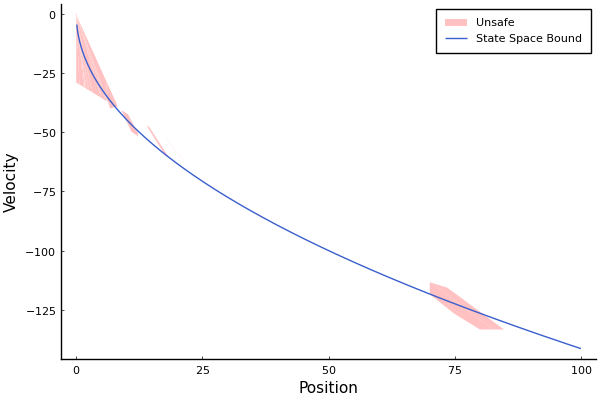

In [35]:
fig_approx3, acc_large_approx3 = plot_acc("acc-2000000-64-64-64-64/results-approx-3.jld")
fig_approx3

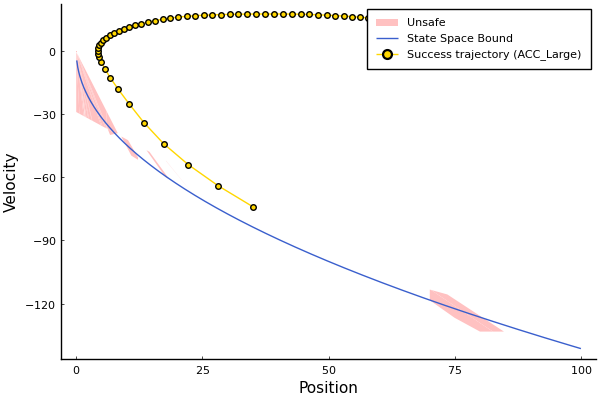

In [36]:
trajectory_fig_approx3 = plot_simulation(fig_approx3,"training/ppo_acc_bigger_200000_steps.onnx", [35., -74.],"Success trajectory (ACC_Large)",:gold,:circle)

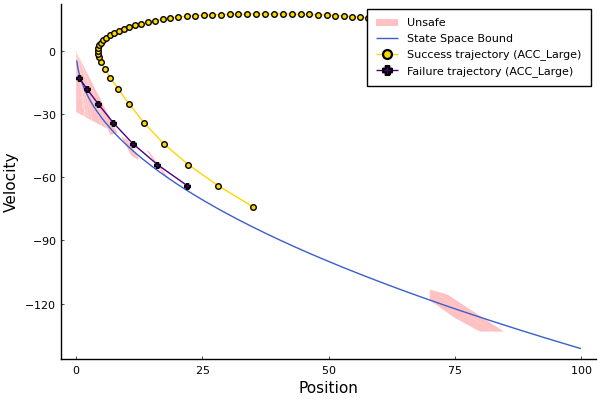

In [37]:
trajectory_fig_approx3 = plot_simulation(trajectory_fig_approx3,"training/ppo_acc_bigger_200000_steps.onnx", [22., -64.],"Failure trajectory (ACC_Large)",:indigo,:cross)

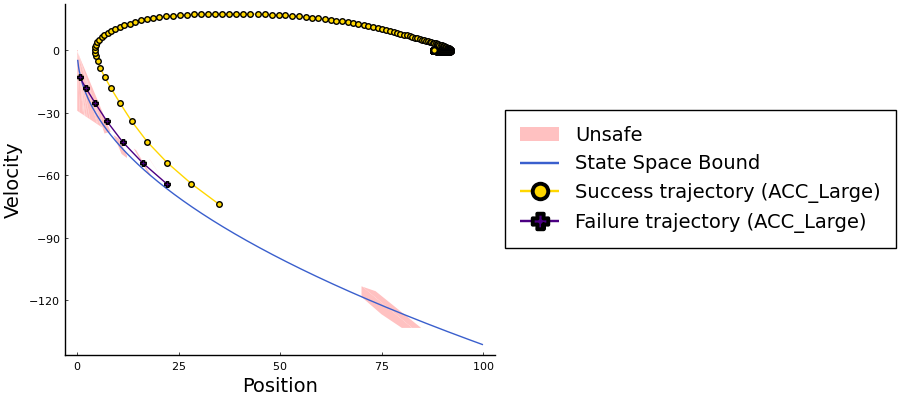

In [40]:
trajectory_plot = plot(trajectory_fig_approx3,legend_position=:outerright,size=(900,400),
legendfontsize=14,xguidefontsize=14,yguidefontsize=14,background_color_legend="rgba(255,255,255,1.0)")

In [41]:
savefig(trajectory_plot,"trajectory_plot.eps")

"/home/samuel/Dokumente/Projects/CPS/NN-Safety-via-dL/repos/NCubeV/experiments/acc/trajectory_plot.eps"